<a href="https://colab.research.google.com/github/goku2130/workspace/blob/master/GAN_training_in_action.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generative Adversarial Network using Tensorflow


In [ ]:
!rm -rf *.png
!ls

dgan.gif  sample_data  training_checkpoints


In [ ]:
!pip install -q imageio
!pip install ipython

In [ ]:
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_probability as tfp
import time
import PIL
import imageio

The data distribution that we intend to generate is defined by creating a mixture of Gaussians with varying means and a constant variance. For simplicity, we generate a 2 dimensional vector. The cross represents the gaussian means and the blue spots are the sampled data points. Please note that the sample means are not equiprobable and can be changed using **p_means**. 

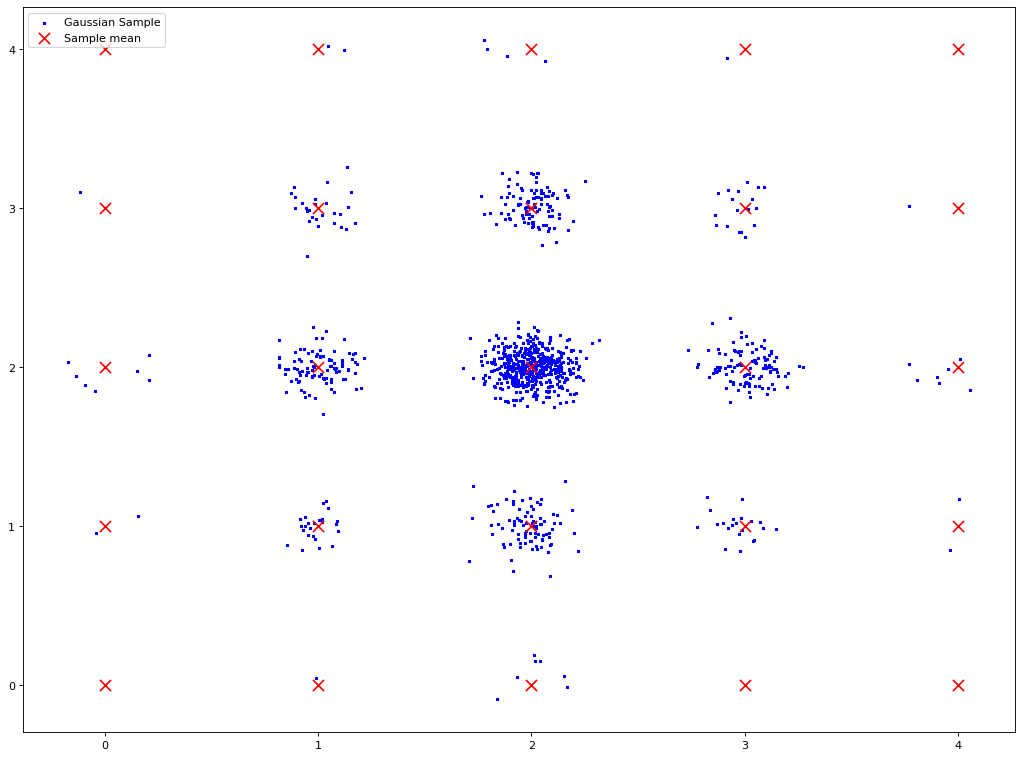

In [ ]:
def generate_batch(batch_len = 256, variance = 0.1):
  
  p_means = [0.01, 0.15, 0.68, 0.15, 0.01]
  means_dist = tfp.distributions.Categorical(probs=p_means, validate_args=False, name='Multinomial')
  x_means_sample = means_dist.sample(batch_len)
  y_means_sample = means_dist.sample(batch_len)
  points = tf.cast(tf.concat([tf.reshape(x_means_sample,[-1, 1]),tf.reshape(y_means_sample,[-1, 1])], 1), dtype=tf.float32)
  norm_dist = tfp.distributions.Normal(points, variance)
  batch = tf.squeeze(norm_dist.sample(1))
  return(batch)

batch = generate_batch(1024)
def plot_data(batch):

  means = np.array([[x,y] for x in range(5) for y in range(5)]).reshape(25,2)
  fig = plt.figure(figsize=(16, 12), dpi=80, facecolor='w', edgecolor='k')
  ax1 = fig.add_subplot(111)
  ax1.scatter(batch[:, 0], batch[:,1], s=2.0, c='b', marker="s", label='Gaussian Sample')
  ax1.scatter(means[:, 0], means[:,1], s=100, c='r', marker="x", label='Sample mean')
  plt.legend(loc='upper left')
  plt.show()

plot_data(batch)

We define the models for both generator and discriminators.
1. Generator model will generate 2 dimensional output from some latent  gaussian random vector essentially learning the distribution of the 2-dim distribution we created earlier. 

2. Discriminator Model will classify a batch of 2 dim datapoints as fake or true datapoints. 

In [ ]:
def model_layer(model: tf.keras.Sequential, inputs, outputs, alpha, normalize = False, bias = True):
  layer = tf.keras.layers.Dense(units = outputs, use_bias = bias, input_shape = (inputs,))
  model.add(layer)
  if normalize:
    model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.LeakyReLU(alpha = alpha))
  return model

## Generator Model

1. Generator output dim: 2 (fixed)
2. Generator input dim: 100 (Can be changed)
3. No. of Layers: 2 (Fixed)
4. Activation: LeakyRelu


In [ ]:
def generator_model(latent_dim = 100, layer = [256, 32], gen_dim = 2):
  model = tf.keras.Sequential()
  model = model_layer(model, inputs = latent_dim, outputs = layer[0], alpha=0.2, normalize = True, bias = False)
  model = model_layer(model, inputs = layer[0], outputs = layer[1], alpha=0.2, normalize = True, bias = True)
  model = model_layer(model, inputs = layer[1], outputs = gen_dim, alpha=0.2, normalize = False, bias = True)
  model.summary()
  return model
  
gen_model = generator_model()
noise = tf.random.normal([1, 100])
gen_data = gen_model(noise,  training=False)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               25600     
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                8224      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32)                128       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 6

In [ ]:
gen_data

<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[ 0.05343532, -0.12633668]], dtype=float32)>

## Discriminator Model

1. Disriminator output dim: 21 (fixed.. its binary classification)
2. Disriminator input dim: 2 (Depending on the data dimension)
3. No. of Layers: 2 (Fixed)
4. Activation: LeakyRelu

In [ ]:
def discriminator_model(gen_dim = 2, layer = [256, 32], class_dim = 1):
  model = tf.keras.Sequential()
  model = model_layer(model, inputs = gen_dim, outputs = layer[0], alpha=0.2, normalize = True, bias = False)
  model = model_layer(model, inputs = layer[0], outputs = layer[1], alpha=0.2, normalize = True, bias = True)
  model = model_layer(model, inputs = layer[1], outputs = class_dim, alpha=0.2, normalize = False, bias = True)
  model.summary()
  return model
dis_model = discriminator_model()
classifier_output = dis_model(gen_data)
classifier_output

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 256)               512       
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                8224      
_________________________________________________________________
batch_normalization_3 (Batch (None, 32)                128       
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 32)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.01023214]], dtype=float32)>

In [ ]:
def log_loss(classifier_output, actual_output): 
  return ( -actual_output*tf.keras.backend.log(classifier_output) - (1 - actual_output)*tf.keras.backend.log(1 - classifier_output))

In [ ]:
def loss(model, x, y, is_training):
  y_ = model(x, training = is_training)
  return(log_loss(classifier_output = y_, actual_output = y))

In [ ]:
def grad(model, inputs, output):
  with tf.GradientTape() as tape:
    loss_value = loss(model, inputs, targets, training=True)
  return loss_value, tape.gradient(loss_value, model.trainable_variables)

### Loss

1. Discriminator Loss: Sum of 2 misclassification losses for real and fake data. Real data should be classified as class 1 and Fake data should be classified as class 0. When we have the a trained generator and an equally trained discriminator, then the fake outputs become as good as real outputs. This is the intuition for the generator loss.

2. Generator Loss: Mis classification loss to check how far we have reached to classify the fake outputs to be coming from real data.

In [ ]:
cross_entropy =  tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss
    
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

### Model Specifications and Hyperparameters

In [ ]:
options = dict()
options['learning_rate'] = 1e-4
options['batch_len'] = 64
options['noise_variance'] = 0.1
options['gen_latent_dim'] = 100
options['gen_layers'] = [128, 64]
options['dis_layers'] = [16, 16]
options['data_size'] = 10000

In [ ]:
gen_model = generator_model(latent_dim = options['gen_latent_dim'], layer = options['gen_layers'])
gen_optimizer = tf.keras.optimizers.Adam(options['learning_rate'])

dis_model = discriminator_model(layer = options['dis_layers'])
dis_optimizer = tf.keras.optimizers.Adam(options['learning_rate'])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 128)               12800     
_________________________________________________________________
batch_normalization_4 (Batch (None, 128)               512       
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 64)                8256      
_________________________________________________________________
batch_normalization_5 (Batch (None, 64)                256       
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 64)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 2)                

In [ ]:
@tf.function
def train_step(real_data):
    noise = tf.random.normal([options['batch_len'], options['gen_latent_dim']])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      gen_fake_data = gen_model(noise, training=True)

      real_output_class = dis_model(real_data, training=True)
      fake_output_class = dis_model(gen_fake_data, training=True)

      gen_loss = generator_loss(fake_output_class)
      disc_loss = discriminator_loss(real_output_class, fake_output_class)
      #gen_loss_hist.extend(gen_loss.eval(session=tf.compat.v1.Session())    )
      #disc_loss_hist.extend(disc_loss.eval(session=tf.compat.v1.Session())   )
      
    gradients_of_generator = gen_tape.gradient(gen_loss, gen_model.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, dis_model.trainable_variables)

    gen_optimizer.apply_gradients(zip(gradients_of_generator, gen_model.trainable_variables))
    dis_optimizer.apply_gradients(zip(gradients_of_discriminator, dis_model.trainable_variables))
    return gen_loss,disc_loss

In [ ]:
!rm -rf './training_checkpoints'
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_gan")
checkpoint = tf.train.Checkpoint(gen_optimizer=gen_optimizer,
                                 dis_optimizer=dis_optimizer,
                                 gen_model=gen_model,
                                 dis_model=dis_model)

### Generate Real data Batches

In [ ]:
real_data = generate_batch(options['data_size'])
real_data = tf.data.Dataset.from_tensor_slices(real_data)
real_data_batch = real_data.batch(options['batch_len'], drop_remainder = True)

### Training the Models

In [ ]:
def train(dataset, epochs):
  num_examples_to_generate = 1024
  gen_loss_hist = []
  disc_loss_hist = []
  seed = tf.random.normal([num_examples_to_generate, options['gen_latent_dim']])

  plot_data(gen_model(seed))
  
  for epoch in range(epochs):
    start = time.time()
    epoch_gen_loss_avg = tf.keras.metrics.Mean()
    epoch_disc_loss_avg = tf.keras.metrics.Mean()
    for real_data_batch in dataset:
      gen_loss,disc_loss = train_step(real_data_batch)
      epoch_gen_loss_avg.update_state(gen_loss)
      epoch_disc_loss_avg.update_state(disc_loss)
      
    gen_loss_hist.append(epoch_gen_loss_avg.result())
    disc_loss_hist.append(epoch_disc_loss_avg.result())
    generate_and_save_images(gen_model,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 25 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)
      #print(epoch_gen_loss_avg.result())
      #print(epoch_disc_loss_avg.result())
      #plot_data(gen_model(seed))
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
  plot_data(gen_model(seed))
  fig, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
  fig.suptitle('GAN Training Metrics')

  axes[0].set_ylabel("Generator Loss", fontsize=14)
  axes[0].plot((gen_loss_hist))

  axes[1].set_ylabel("Discriminator Loss", fontsize=14)
  axes[1].set_xlabel("Epoch", fontsize=14)
  axes[1].plot((disc_loss_hist))
  plt.show()

In [ ]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  means = np.array([[x,y] for x in range(5) for y in range(5)]).reshape(25,2)
  predictions = model(test_input, training=False)
  fig = plt.figure(figsize=(16, 12), dpi=80, facecolor='w', edgecolor='k')
  ax1 = fig.add_subplot(111)
  ax1.scatter(predictions[:, 0], predictions[:,1], s=2.0, c='b', marker="s", label='Gaussian Sample')
  ax1.scatter(means[:, 0], means[:,1], s=100, c='r', marker="x", label='Sample mean')
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  #plt.show()
  plt.close('all') 

In [ ]:
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

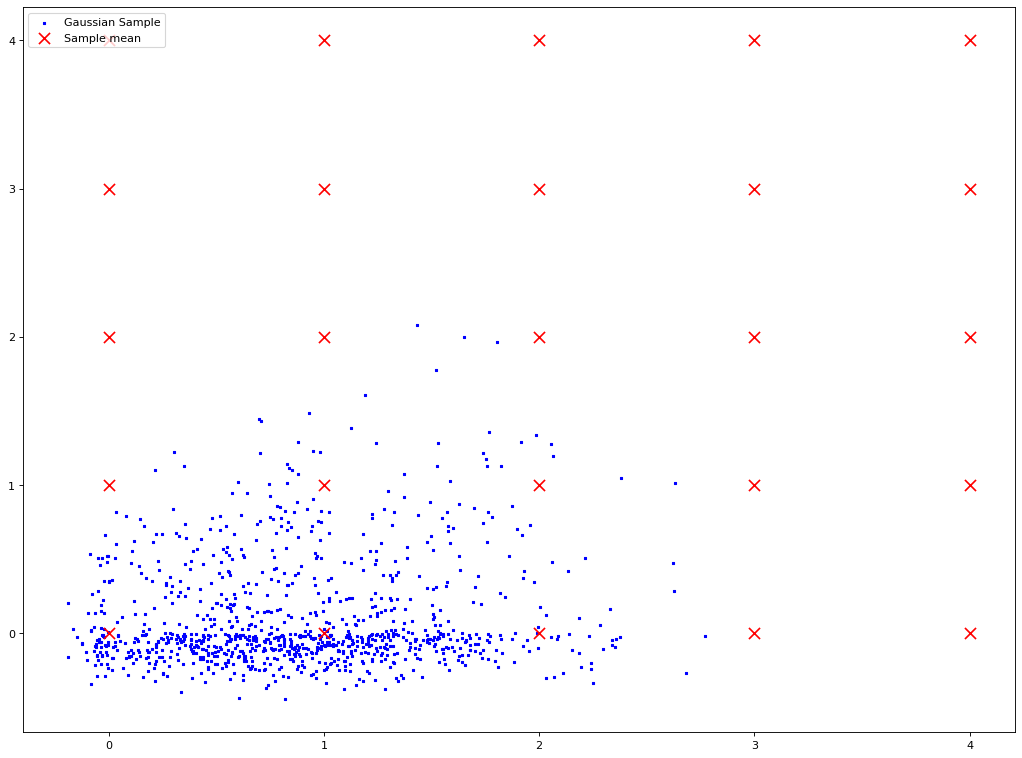

Time for epoch 1 is 3.6566765308380127 sec
Time for epoch 2 is 1.267470359802246 sec
Time for epoch 3 is 1.2478904724121094 sec
Time for epoch 4 is 1.2869186401367188 sec
Time for epoch 5 is 1.2633471488952637 sec
Time for epoch 6 is 1.254176139831543 sec
Time for epoch 7 is 1.2974052429199219 sec
Time for epoch 8 is 1.2970354557037354 sec
Time for epoch 9 is 1.2795350551605225 sec
Time for epoch 10 is 1.2752685546875 sec
Time for epoch 11 is 1.2579216957092285 sec
Time for epoch 12 is 1.300194263458252 sec
Time for epoch 13 is 1.269221305847168 sec
Time for epoch 14 is 1.2549633979797363 sec
Time for epoch 15 is 1.2848620414733887 sec
Time for epoch 16 is 1.3040180206298828 sec
Time for epoch 17 is 1.2891907691955566 sec
Time for epoch 18 is 1.294112205505371 sec
Time for epoch 19 is 1.2783663272857666 sec
Time for epoch 20 is 1.2605416774749756 sec
Time for epoch 21 is 1.2663626670837402 sec
Time for epoch 22 is 1.2758126258850098 sec
Time for epoch 23 is 1.2816684246063232 sec
Time 

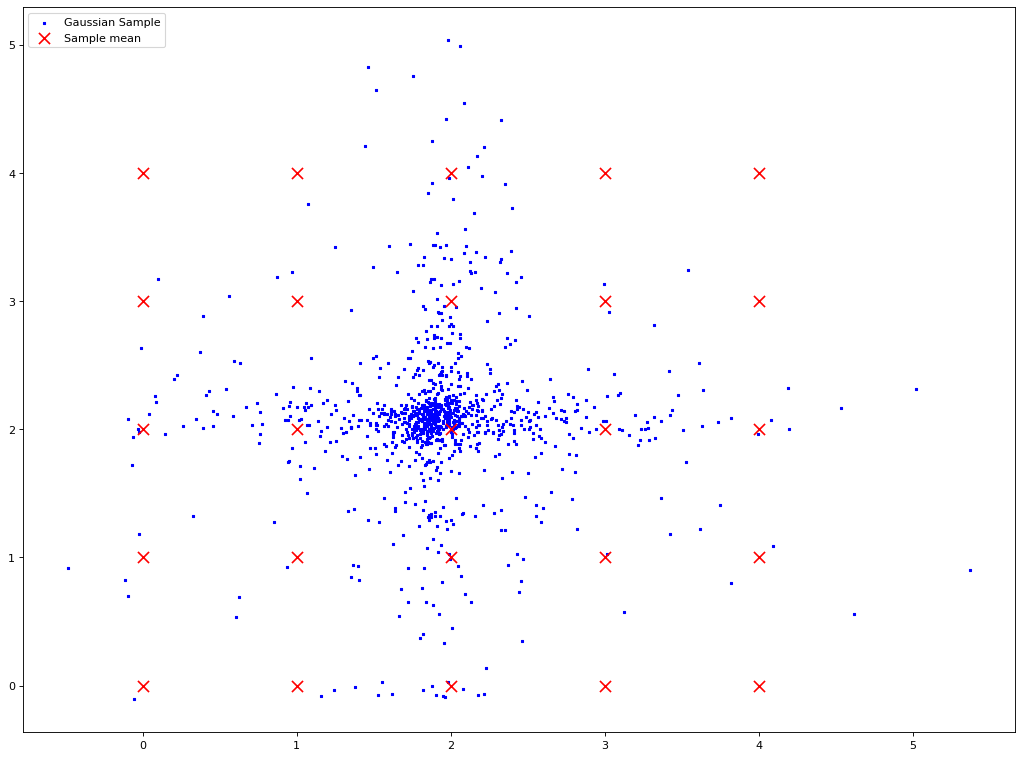

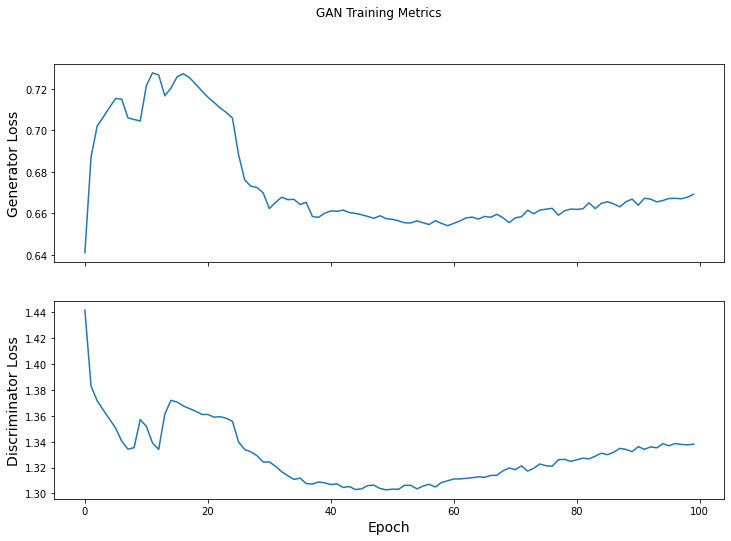

In [ ]:
anim_file = 'dgan.gif'

train(real_data_batch, 100)


In [ ]:
!rm -rf 'dgan.gif'
import glob
with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

### Final Generator distribution after training

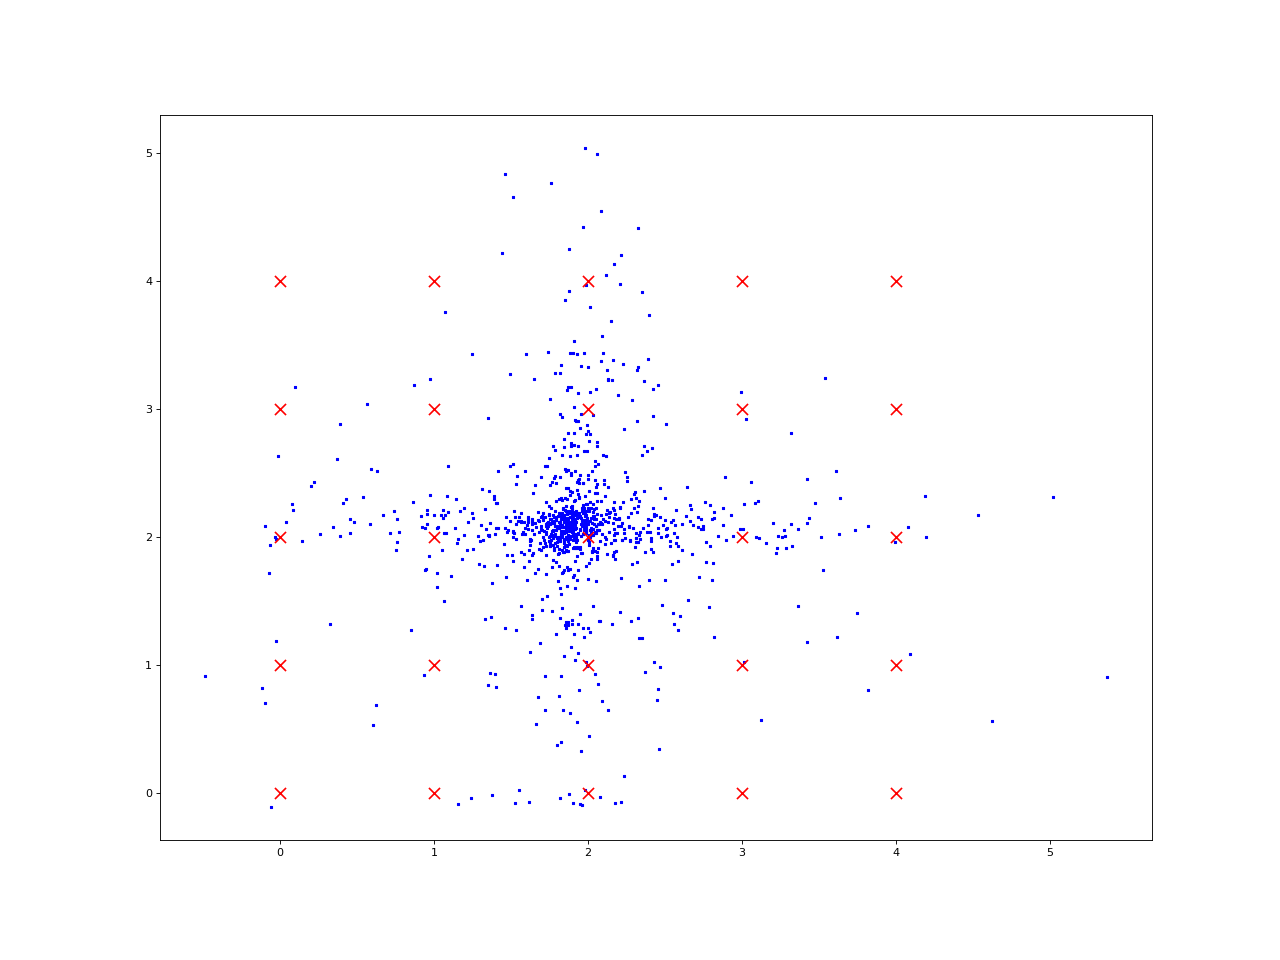

In [ ]:
display_image(100)

In [ ]:
from IPython import display
import IPython
if IPython.version_info > (6,2,0,''):
  display.Image(filename=anim_file)
IPython.version_info 

(5, 5, 0, '')

In [ ]:
ls

dgan.gif                 image_at_epoch_0035.png  image_at_epoch_0070.png
image_at_epoch_0001.png  image_at_epoch_0036.png  image_at_epoch_0071.png
image_at_epoch_0002.png  image_at_epoch_0037.png  image_at_epoch_0072.png
image_at_epoch_0003.png  image_at_epoch_0038.png  image_at_epoch_0073.png
image_at_epoch_0004.png  image_at_epoch_0039.png  image_at_epoch_0074.png
image_at_epoch_0005.png  image_at_epoch_0040.png  image_at_epoch_0075.png
image_at_epoch_0006.png  image_at_epoch_0041.png  image_at_epoch_0076.png
image_at_epoch_0007.png  image_at_epoch_0042.png  image_at_epoch_0077.png
image_at_epoch_0008.png  image_at_epoch_0043.png  image_at_epoch_0078.png
image_at_epoch_0009.png  image_at_epoch_0044.png  image_at_epoch_0079.png
image_at_epoch_0010.png  image_at_epoch_0045.png  image_at_epoch_0080.png
image_at_epoch_0011.png  image_at_epoch_0046.png  image_at_epoch_0081.png
image_at_epoch_0012.png  image_at_epoch_0047.png  image_at_epoch_0082.png
image_at_epoch_0013.png  image_at_epoc

In [ ]:
try:
  from google.colab import files
except ImportError:
   pass
else:
  files.download(anim_file)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>